# Logistic Regression

Tudor Berariu, Andrei Nica, 2018

In [32]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

FIG_SIZE=(12,8)

## Two datasets

In [33]:
def two_clusters(N, variance=0.1):
    N1 = N // 2
    N2 = N - N1
    X1 = np.random.randn(N1, 2) * variance + 0.25
    X2 = np.random.randn(N2, 2) * variance + 0.75
    X = np.concatenate([X1, X2], axis=0)
    T = np.concatenate([np.zeros((N1)), np.ones((N2))], axis=0)
    p = np.random.permutation(N)
    return X[p], T[p]

def two_rings(N, separation=0.1, noise=0.2):
    N1 = N // 2
    N2 = N - N1
    angles = np.random.rand(N, 1) * 2 * np.pi
    radius = np.random.rand(N, 1) + np.random.randn(N, 1) * noise
    radius *= .5 - separation / 2
    radius[N2:] += .5 + separation / 2
    X = np.concatenate([radius * np.sin(angles), radius * np.cos(angles)], axis=1)
    T = np.concatenate([np.zeros((N1)), np.ones((N2))], axis=0)
    p = np.random.permutation(N)
    return X[p], T[p]

In [100]:
def visualize_dataset(X, T, Y=None):
    m = ["x", "o"]  # Indicates true class
    col = ["red", "blue"]  # Indicates prediction
    fig = plt.figure(figsize=FIG_SIZE); plt.axis('equal')
    if Y is not None:
        idx_tp = np.logical_and(T >= .5, Y >= .5) # True positives
        idx_fp = np.logical_and(T < .5, Y >= .5) # False positives
        idx_fn = np.logical_and(T >= .5, Y < .5) # False negatives
        idx_tn = np.logical_and(T < .5, Y < .5) # True negatives
        
        plt.scatter(X[idx_tp,0], X[idx_tp,1], marker=m[0], c="red", label="TP")
        plt.scatter(X[idx_fp,0], X[idx_fp,1], marker=m[1], c="red", label="FP")
        plt.scatter(X[idx_fn,0], X[idx_fn,1], marker=m[0], c="blue", label="FN")
        plt.scatter(X[idx_tn,0], X[idx_tn,1], marker=m[1], c="blue", label="TN")

    else:
        idx_pos, idx_neg = (T > .5), (T < .5)
        plt.scatter(X[idx_pos,0], X[idx_pos,1], marker=m[0], color="blue", label="Pos")
        plt.scatter(X[idx_neg,0], X[idx_neg,1], marker=m[1], color="blue", label="Neg")
    
    plt.xlabel("x"); plt.ylabel("y")
    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    return fig.axes[0]

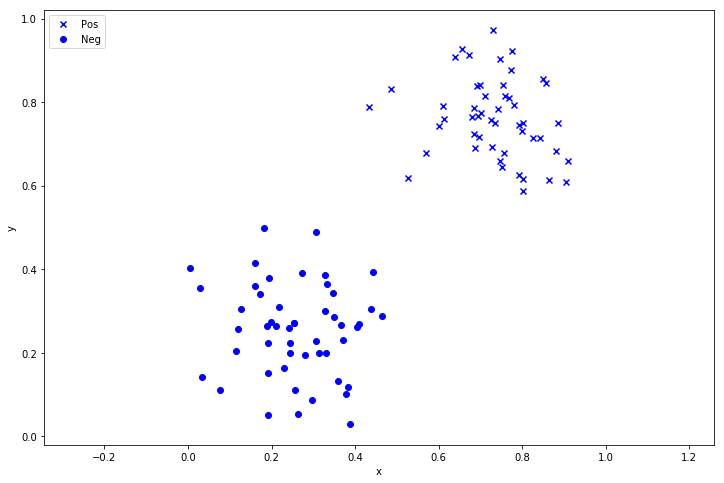

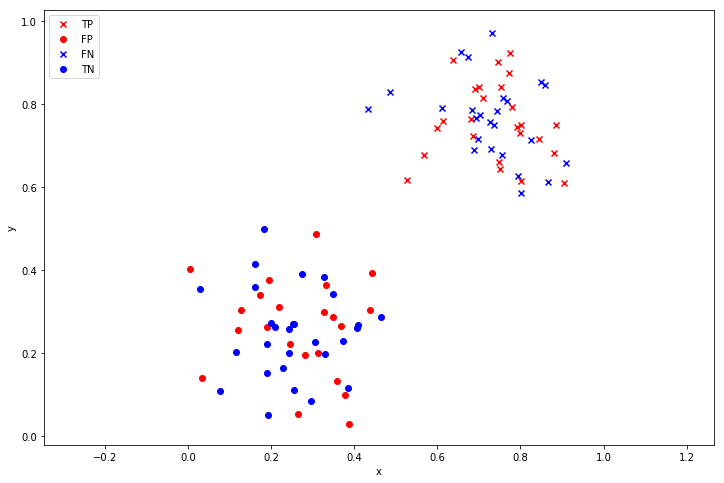

In [101]:
X, T = two_clusters(100, variance=0.1)
visualize_dataset(X, T, Y=None);
visualize_dataset(X, T, Y=np.random.uniform(size=T.size));

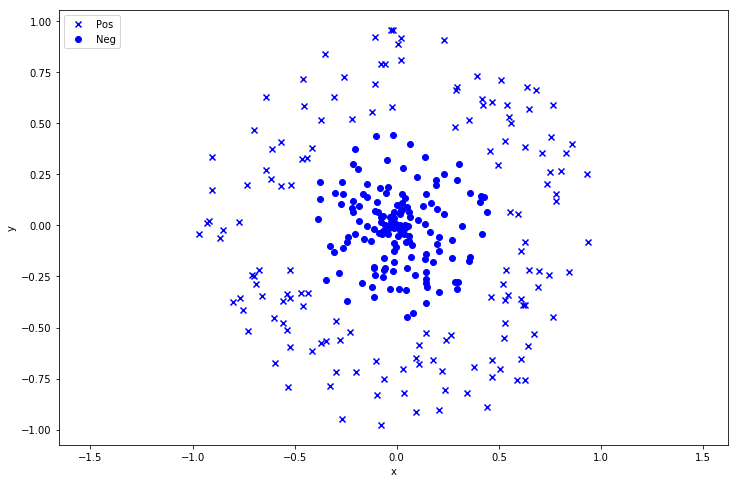

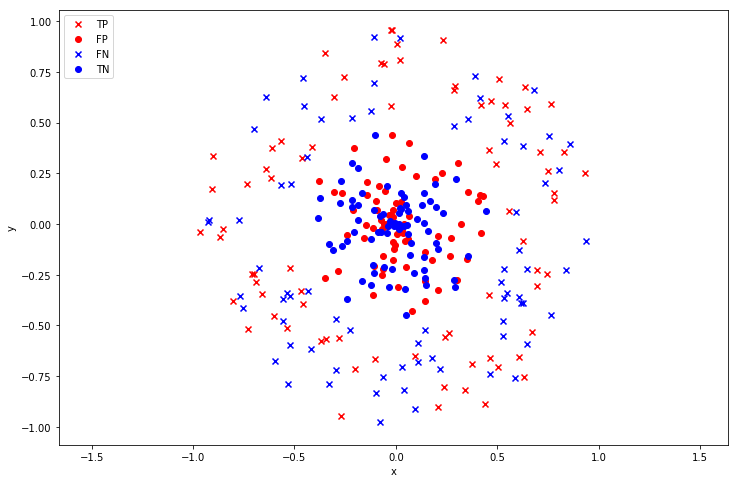

In [102]:
X, T = two_rings(300, noise=0.01)
visualize_dataset(X, T, Y=None);
visualize_dataset(X, T, Y=np.random.uniform(size=T.size));

## Using linear regression for classification?

We'll use the following convention: ${\bf w}^{\text{T}}{\bf x} + b = 1$ for positive examples and ${\bf w}^{\text{T}}{\bf x} +b = 0$ for negative examples.

Actually: $\hat{x} = [x_0, x_1, 1]$ and $y = {\bf w}^{\text{T}}\hat{{\bf x}}$

In [103]:
def train_linear(X, T):
    N = X.shape[0]
    X_hat = np.concatenate([X, np.ones((N, 1))], axis=1)
    W = np.dot(np.linalg.pinv(X_hat), T)
    return W

In [104]:
def predict_linear(X, W):
    N = X.shape[0]
    X_hat = np.concatenate([X, np.ones((N, 1))], axis=1)
    Y = np.dot(X_hat, W)
    return Y

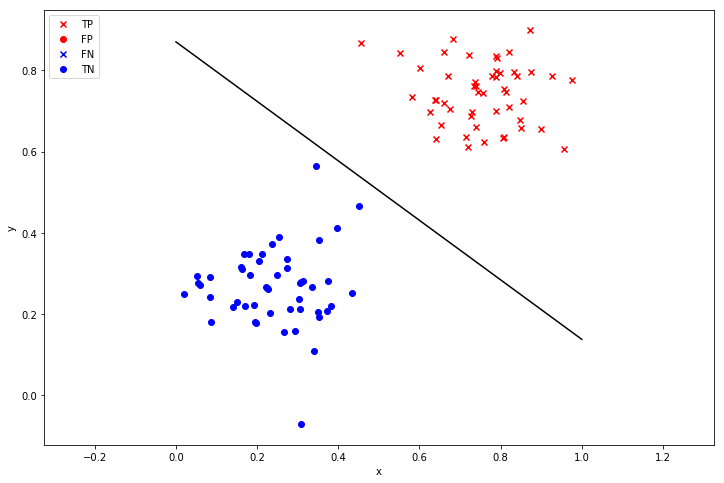

In [105]:
X, T = two_clusters(100, variance=0.1)
W = train_linear(X, T)
Y = predict_linear(X, W)
ax = visualize_dataset(X, T, Y);

__x = np.linspace(0, 1, 100)
__y = (.5 - __x * W[0] - W[2]) / W[1]

plt.plot(__x, __y, c="black", axes=ax)
plt.show()

### How about adding some other examples that should pose no problems?

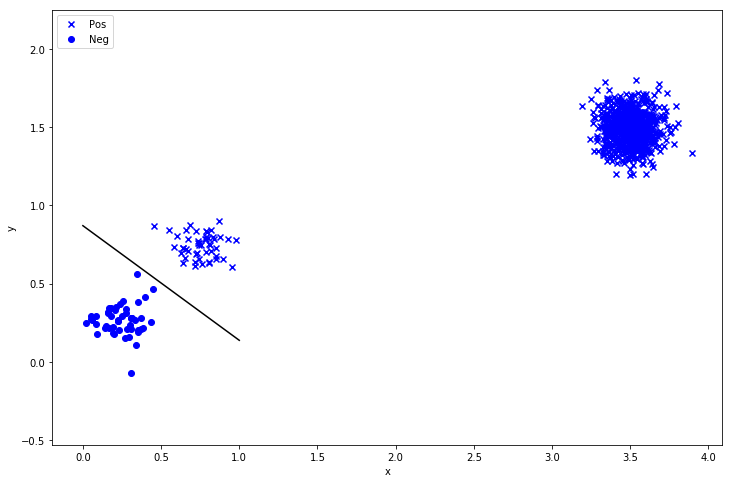

In [106]:
extra_N = 800
extra_X = np.random.randn(extra_N, 2) * 0.1
extra_X[:,1] += 1.5
extra_X[:,0] += 3.5
extra_T = np.ones(extra_N)
X_full = np.concatenate([X, extra_X], axis=0)
T_full = np.concatenate([T, extra_T], axis=0)

ax = visualize_dataset(X_full, T_full, Y=None);
__x = np.linspace(0, 1, 100)
__y = (.5 - __x * W[0] - W[2]) / W[1]

plt.plot(__x, __y, c="black", axes=ax)
plt.show()

### Let's train the model on full data

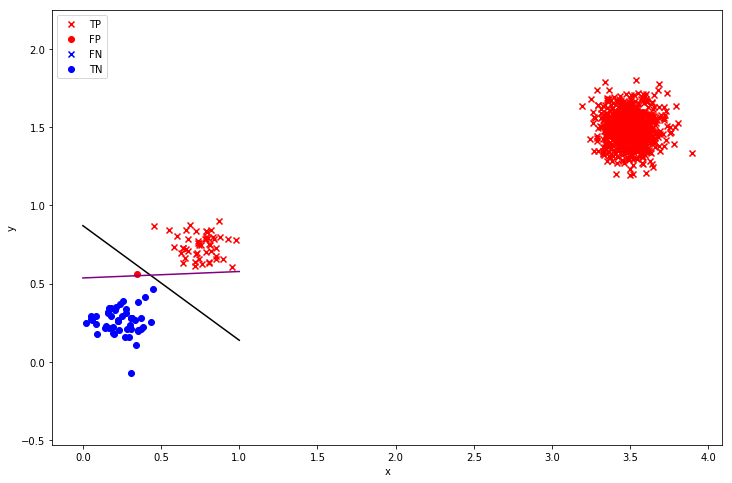

In [107]:
W_full = train_linear(X_full, T_full)
Y = predict_linear(X_full, W_full)
ax = visualize_dataset(X_full, T_full, Y);

__x = np.linspace(0, 1, 100)
__y = (.5 - __x * W[0] - W[2]) / W[1]
plt.plot(__x, __y, c="black", axes=ax)

__y = (.5 - __x * W_full[0] - W_full[2]) / W_full[1]
plt.plot(__x, __y, c="purple", axes=ax)


plt.show()

## The logistic function

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$


In [108]:
def logistic(x):
    return 1. / (1. + np.exp(-x))

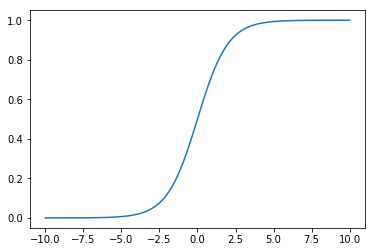

In [109]:
x = np.linspace(-10, 10, 100)
plt.plot(x, logistic(x))

## Learning models for classification

In [110]:
def nll(Y, T):
    idx0 = (T > 0.5)
    idx1 = (T < 0.5)
    return -np.sum(np.log(Y[idx0])) - np.sum(np.log(1.0 - Y[idx1]))

def accuracy(Y, T):
    N = Y.shape[0]
    return np.sum(((T < 0.5) & (Y < 0.5)) | ((T > 0.5) & (Y > 0.5))) / N

print("NLL:", nll(np.random.uniform(size=(100)), T))
print("Accuracy: ", accuracy(np.random.uniform(size=(100)), T))

NLL: 101.61745989890434
Accuracy:  0.48


## Logistic regression

In [111]:
def train_logistic(X, T, lr=.01, epochs_no=10):
    (N, D) = X.shape
    X_hat = np.concatenate([X, np.ones((N, 1))], axis=1)
    W = np.random.randn((D+1))

    for epoch in range(epochs_no):
        Y = logistic(np.dot(X_hat, W))
        W -= lr * (np.dot(X_hat.T, Y - T) / N)
        
    return W

def predict_logistic(X, W):
    N = X.shape[0]
    X_hat = np.concatenate([X, np.ones((N, 1))], axis=1)
    Y = logistic(np.dot(X_hat, W))
    return Y

### Let's test it!

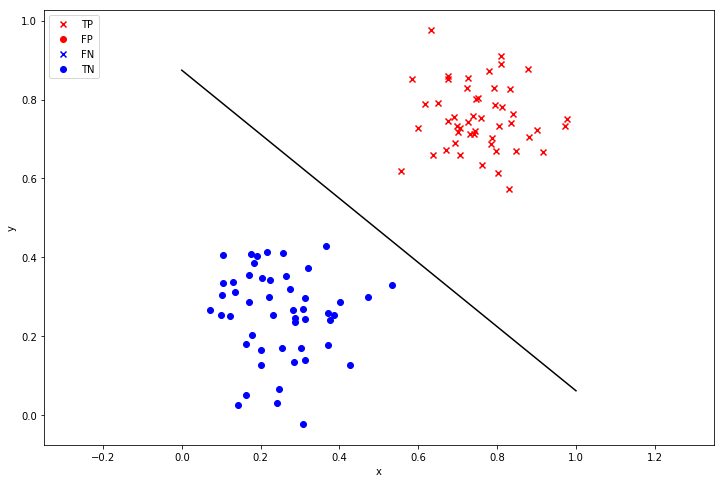

In [162]:
X, T = two_clusters(100, variance=0.1)
W = train_logistic(X, T, lr=.1, epochs_no=1000)
Y = predict_logistic(X, W)
ax = visualize_dataset(X, T, Y);

__x = np.linspace(0, 1, 100)
__y = (-__x * W[0] - W[2]) / W[1]

plt.plot(__x, __y, c="black", axes=ax)
plt.show()

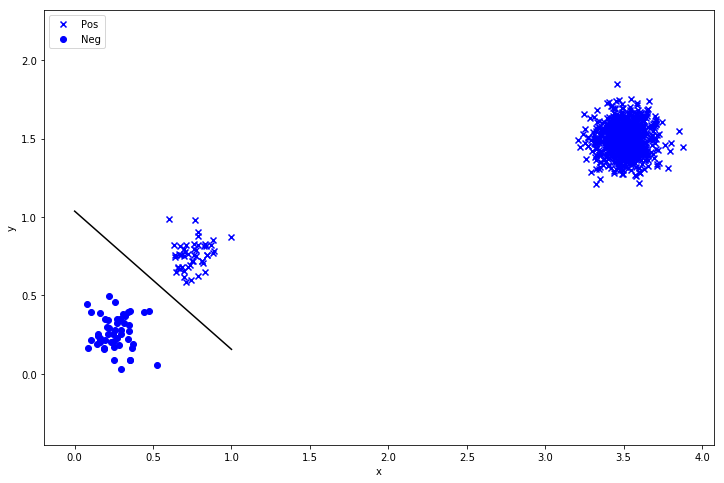

In [126]:
extra_N = 800
extra_X = np.random.randn(extra_N, 2) * 0.1
extra_X[:,1] += 1.5
extra_X[:,0] += 3.5
extra_T = np.ones(extra_N)
X_full = np.concatenate([X, extra_X], axis=0)
T_full = np.concatenate([T, extra_T], axis=0)

ax = visualize_dataset(X_full, T_full, Y=None);
__x = np.linspace(0, 1, 100)
__y = (.5 - __x * W[0] - W[2]) / W[1]

plt.plot(__x, __y, c="black", axes=ax)
plt.show()

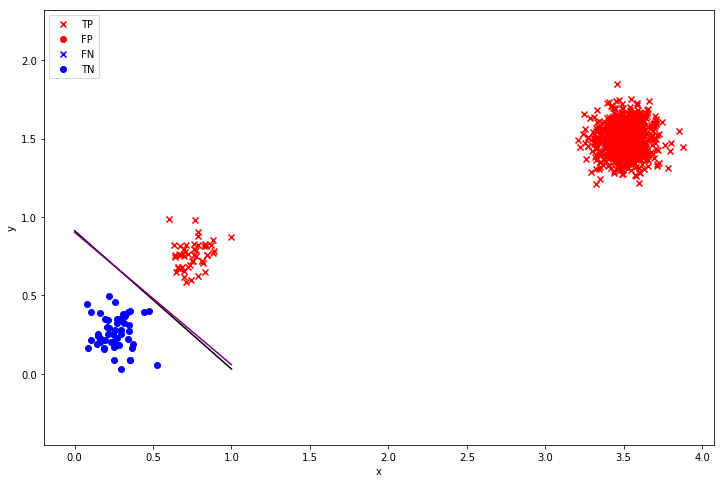

In [138]:
W_full = train_logistic(X_full, T_full, lr=.1, epochs_no=10000)
Y = predict_logistic(X_full, W_full)
ax = visualize_dataset(X_full, T_full, Y);

__x = np.linspace(0, 1, 100)
__y = (- __x * W[0] - W[2]) / W[1]
plt.plot(__x, __y, c="black", axes=ax)

__y = (- __x * W_full[0] - W_full[2]) / W_full[1]
plt.plot(__x, __y, c="purple", axes=ax)


plt.show()

### What happens?

In [143]:
def train_logistic_full(X, T, lr=.01, epochs_no=100):
    (N, D) = X.shape
    X1 = np.concatenate([np.ones((N, 1)), X], axis=1)

    N_train = N // 2
    N_test = N - N_train

    X_train, X_test = X1[:N_train,:], X1[N_train:,:]
    T_train, T_test = T[:N_train], T[N_train:]

    W = np.random.randn((D+1))


    train_acc, test_acc = [], []
    train_nll, test_nll = [], []
    W_trace = [W.copy()]

    for epoch in range(epochs_no):
        Y_train = logistic(np.dot(X_train, W))
        # Update parameters
        W -= lr * np.dot(X_train.T, Y_train-T_train)

        # Just for plotting
        Y_test = 1. / (1. + np.exp(-np.dot(X_test, W)))
        train_acc.append(accuracy(Y_train, T_train))
        test_acc.append(accuracy(Y_test, T_test))
        train_nll.append(nll(Y_train, T_train))
        test_nll.append(nll(Y_test, T_test))
        W_trace.append(W.copy())
        
    return W, train_acc, test_acc, train_nll, test_nll, W_trace

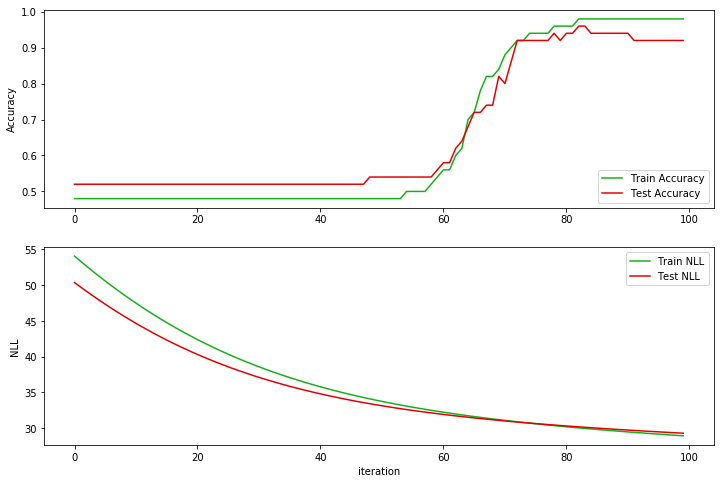

In [159]:
EPOCHS_NO = 100
results = train_logistic_full(X, T, lr=.001, epochs_no=EPOCHS_NO)

W, train_acc, test_acc, train_nll, test_nll, W_trace = results

fig, (ax1, ax2) = plt.subplots(2,1, figsize=FIG_SIZE);
ax1.plot(range(EPOCHS_NO), train_acc, sns.xkcd_rgb["green"], label="Train Accuracy")
ax1.plot(range(EPOCHS_NO), test_acc, sns.xkcd_rgb["red"], label="Test Accuracy")
ax1.set_ylabel("Accuracy")
ax1.legend(loc='lower right', ncol=1)

ax2.plot(range(EPOCHS_NO), train_nll, sns.xkcd_rgb["green"], label="Train NLL")
ax2.plot(range(EPOCHS_NO), test_nll, sns.xkcd_rgb["red"], label="Test NLL")
ax2.set_xlabel("iteration")
ax2.set_ylabel("NLL")
ax2.legend(loc='upper right', ncol=1);


## What about the second dataset?

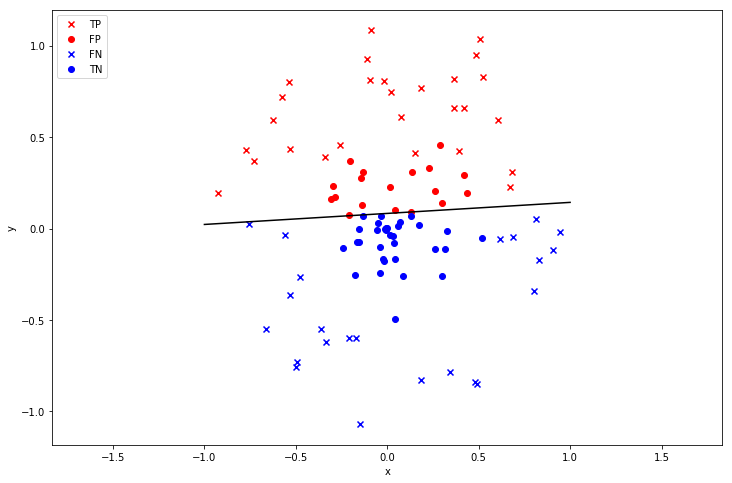

In [166]:
X, T = two_rings(100)
W = train_logistic(X, T, lr=.1, epochs_no=1000)
Y = predict_logistic(X, W)
ax = visualize_dataset(X, T, Y);

__x = np.linspace(-1, 1, 100)
__y = (-__x * W[0] - W[2]) / W[1]

plt.plot(__x, __y, c="black", axes=ax)
plt.show()